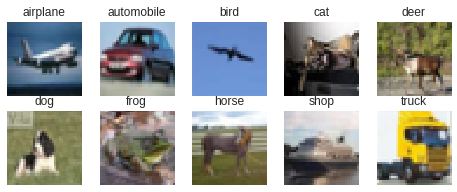

y_train length: 10000
x_train length: 10000
y_test length: 2000
x_test length: 2000


In [5]:
# Import important libraries and methods
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.convolutional import Conv3D, MaxPooling3D
import pandas as pd
from keras import backend as K
#for the gridsearch import:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras import optimizers
from keras.constraints import maxnorm

if K.backend()=='tensorflow':
    K.set_image_dim_ordering("th")

# input image dimensions
img_rows, img_cols = 32, 32   

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = cifar10.load_data() 

# Important Hyperparameters
batch_size = 32 
num_classes = 2
epochs = 30 #first 30 epochs to define which hyperparameters are better

# Plot sample image from each cifar10 class.
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','shop','truck']
fig = plt.figure(figsize=(8,3))
for i in range(10):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(y_train[:]==i)[0]
    features_idx = x_train[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = np.transpose(features_idx[img_num,::],(1,2,0))
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

# Only look at cats [=3] and dogs [=5]
train_picks = np.ravel(np.logical_or(y_train==3,y_train==5))  
test_picks = np.ravel(np.logical_or(y_test==3,y_test==5))     

y_train = np.array(y_train[train_picks]==5,dtype=int)
y_test = np.array(y_test[test_picks]==5,dtype=int)

x_train = x_train[train_picks]
x_test = x_test[test_picks]

# check for image_data format and format image shape accordingly
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 3, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 3, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 3)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)

# Normalize pixel values between 0 and 1
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# Convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(np.ravel(y_train), num_classes)
y_test = keras.utils.to_categorical(np.ravel(y_test), num_classes)

# Check train and test lengths
print('y_train length:', len(y_train))
print('x_train length:', len(x_train))
print('y_test length:', len(y_test))
print('x_test length:', len(x_test))

#Automatically send results to google drive

In [0]:
#authenticate first so the image is sent automatically withouth asking for the code later
#create the folder to store the files
!pip install -U -q PyDrive
from google.colab import files
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import zipfile
from pydrive.auth import GoogleAuth
import os
import sys
!mkdir /content/results #create the Train folder
auth.authenticate_user()





*   Conv2D - kernel_size = (3,3)
*   Relu Activation
*   Conv2D - kernel_size = (3,3)
*   Relu Activation
*   Max Pooling - pool_size = (2,2)
*   Dropout - use .25 for all layers but the final layer
---
*   Conv2D - kernel_size = (3,3)
*   Relu Activation
*   Conv2D - kernel_size = (3,3)
*   Relu Activation
*   Max Pooling - pool_size = (2,2)
*   Dropout - use .25 for all layers but the final layer
---
*   Flatten
*   Fully-Connected (Dense)
*   Dropout - use .5 this time 
*   Fully-Connected (Dense layer where # neurons = # final classes/labels)

In [0]:
# Function to create model, required for KerasClassifier:
def create_model(optimizer='Adam', learn_rate=0.001, dropout_rate=0.25, weight_constraint=0, neurons=1, neurons2=1):
  model2 = Sequential()
  model2.add(Conv2D(neurons, kernel_size=(3, 3), activation='relu', input_shape=input_shape, kernel_constraint=maxnorm(weight_constraint))) 
  model2.add(Conv2D(neurons2, (3, 3), activation='relu', kernel_constraint=maxnorm(weight_constraint)))
  model2.add(MaxPooling2D(pool_size=(2, 2)))
  model2.add(Dropout(dropout_rate))
  #--------------------------
  model2.add(Conv2D(neurons, kernel_size=(3, 3), activation='relu', input_shape=input_shape, kernel_constraint=maxnorm(weight_constraint))) 
  model2.add(Conv2D(neurons2, (3, 3), activation='relu', kernel_constraint=maxnorm(weight_constraint)))
  model2.add(MaxPooling2D(pool_size=(2, 2)))
  model2.add(Dropout(dropout_rate))
  #--------------------------
  model2.add(Flatten())
  model2.add(Dense(16, activation='relu', kernel_constraint=maxnorm(weight_constraint)))
  model2.add(Dropout(dropout_rate))
  model2.add(Dense(2, activation='softmax', kernel_constraint=maxnorm(weight_constraint)))
  if optimizer == 'Adam':
    optimizer=optimizers.Adam(lr=learn_rate)
  if optimizer == 'RMSprop':
    optimizer=optimizers.RMSprop(lr=learn_rate)
  model2.compile(loss=keras.losses.categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])
  return model2


In [0]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# create model
model = KerasClassifier(build_fn=create_model, verbose=0)
# define the grid search parameters
batch_size = [32]
epochs = [40]#Best: 0.711700 using {'batch_size': 32, 'epochs': 20, 'learn_rate': 0.003, 'optimizer': 'RMSprop'}
optimizer = ['RMSprop']
learn_rate = [0.003]
weight_constraint = [1, 2]#Best: 0.721600 using {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 20, 'learn_rate': 0.003, 'optimizer': 'RMSprop', 'weight_constraint': 1}
dropout_rate = [0.1, 0.2, 0.3]
neurons = [10,12,14]#Best: 0.710200 using {'batch_size': 32, 'dropout_rate': 0.5, 'epochs': 20, 'learn_rate': 0.003, 'neurons': 10, 'neurons2': 14, 'optimizer': 'RMSprop', 'weight_constraint': 4}
neurons2 = [14]
param_grid = dict(learn_rate=learn_rate,batch_size=batch_size, epochs=epochs, optimizer=optimizer, dropout_rate=dropout_rate, weight_constraint=weight_constraint,neurons=neurons, neurons2=neurons2)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1)#if an error appears, change n_jobs to 1 gridsearch is not parallel
grid_result = grid.fit(x_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
output = open("/content/results/log.txt","a")
output.write(str('grid_result.best_score:'+str(grid_result.best_score_)))
output.write('\n')
output.write(str('grid_result.best_params:'+str(grid_result.best_params_)))
output.write('\n')
output.close()
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    output = open("/content/results/log.txt","a")
    output.write(str('mean:'+str(mean)))
    output.write('\n')
    output.write(str('stdev:'+str(stdev)))
    output.write('\n')
    output.write(str('param:'+str(param)))
    output.write('\n')
    output.close()

#Automatically send results to google drive

In [0]:
######################## ZIP AND UPLOAD FOLDER TO DRIVE ########################
zipname = 'log'

def zipfolder(foldername, target_dir):            
    zipobj = zipfile.ZipFile(foldername + '.zip', 'w', zipfile.ZIP_DEFLATED)
    rootlen = len(target_dir) + 1
    for base, dirs, files in os.walk(target_dir):
        for file in files:
            fn = os.path.join(base, file)
            zipobj.write(fn, fn[rootlen:])

zipfolder(zipname, '/content/results')

# 1. Authenticate and create the PyDrive client.
#auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# 2. Create & upload a file text file.
file1 = drive.CreateFile()
file1.SetContentFile(zipname+".zip")
file1.Upload()

## Fit your model

Fit your model and save it to a new variable so that we can access the .history value to make a plot of our training and validation accuracies by epoch.

In [0]:
fitted_model_2 = model2.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test), shuffle=True)

Train on 10000 samples, validate on 2000 samples
Epoch 1/100
10000/10000 [==============================] - 7s 719us/step - loss: 0.6937 - acc: 0.5027 - val_loss: 0.6915 - val_acc: 0.5815
Epoch 2/100
10000/10000 [==============================] - 6s 647us/step - loss: 0.6879 - acc: 0.5363 - val_loss: 0.6745 - val_acc: 0.6015
Epoch 3/100
10000/10000 [==============================] - 6s 644us/step - loss: 0.6662 - acc: 0.6037 - val_loss: 0.6466 - val_acc: 0.6240
Epoch 4/100
 1984/10000 [====>.........................] - ETA: 4s - loss: 0.6525 - acc: 0.6210

10000/10000 [==============================] - 5s 548us/step - loss: 0.6476 - acc: 0.6269 - val_loss: 0.6247 - val_acc: 0.6685
Epoch 5/100
10000/10000 [==============================] - 5s 530us/step - loss: 0.6335 - acc: 0.6449 - val_loss: 0.6251 - val_acc: 0.6460
Epoch 6/100
10000/10000 [==============================] - 6s 555us/step - loss: 0.6312 - acc: 0.6454 - val_loss: 0.6065 - val_acc: 0.6810
Epoch 7/100
 9344/10000 [===========================>..] - ETA: 0s - loss: 0.6205 - acc: 0.6568

10000/10000 [==============================] - 5s 518us/step - loss: 0.6197 - acc: 0.6586 - val_loss: 0.5963 - val_acc: 0.6850
Epoch 8/100
10000/10000 [==============================] - 5s 503us/step - loss: 0.6209 - acc: 0.6596 - val_loss: 0.5843 - val_acc: 0.6935
Epoch 9/100
10000/10000 [==============================] - 5s 494us/step - loss: 0.6115 - acc: 0.6626 - val_loss: 0.5770 - val_acc: 0.7040
Epoch 10/100
10000/10000 [==============================] - 5s 508us/step - loss: 0.6085 - acc: 0.6682 - val_loss: 0.5748 - val_acc: 0.7050
Epoch 11/100
 1408/10000 [===>..........................] - ETA: 4s - loss: 0.6057 - acc: 0.6832

10000/10000 [==============================] - 5s 492us/step - loss: 0.6044 - acc: 0.6762 - val_loss: 0.5678 - val_acc: 0.7080
Epoch 12/100
10000/10000 [==============================] - 5s 505us/step - loss: 0.5958 - acc: 0.6829 - val_loss: 0.5619 - val_acc: 0.7100
Epoch 13/100
10000/10000 [==============================] - 5s 490us/step - loss: 0.5919 - acc: 0.6803 - val_loss: 0.5708 - val_acc: 0.6990
Epoch 14/100
10000/10000 [==============================] - 5s 503us/step - loss: 0.5864 - acc: 0.6929 - val_loss: 0.5484 - val_acc: 0.7185
Epoch 15/100
  256/10000 [..............................] - ETA: 4s - loss: 0.5315 - acc: 0.7422

10000/10000 [==============================] - 5s 469us/step - loss: 0.5842 - acc: 0.6935 - val_loss: 0.5724 - val_acc: 0.6995
Epoch 16/100
10000/10000 [==============================] - 5s 515us/step - loss: 0.5783 - acc: 0.7041 - val_loss: 0.5445 - val_acc: 0.7245
Epoch 17/100
10000/10000 [==============================] - 5s 520us/step - loss: 0.5765 - acc: 0.7048 - val_loss: 0.5942 - val_acc: 0.6815
Epoch 18/100
10000/10000 [==============================] - 5s 460us/step - loss: 0.5693 - acc: 0.7049 - val_loss: 0.5455 - val_acc: 0.7245
Epoch 19/100
  288/10000 [..............................] - ETA: 4s - loss: 0.6152 - acc: 0.6701

10000/10000 [==============================] - 5s 485us/step - loss: 0.5717 - acc: 0.7093 - val_loss: 0.5212 - val_acc: 0.7425
Epoch 20/100
10000/10000 [==============================] - 5s 479us/step - loss: 0.5595 - acc: 0.7163 - val_loss: 0.5857 - val_acc: 0.6970
Epoch 21/100
10000/10000 [==============================] - 5s 454us/step - loss: 0.5650 - acc: 0.7111 - val_loss: 0.5463 - val_acc: 0.7185
Epoch 22/100
10000/10000 [==============================] - 4s 434us/step - loss: 0.5608 - acc: 0.7166 - val_loss: 0.5684 - val_acc: 0.6980
Epoch 23/100
 1568/10000 [===>..........................] - ETA: 3s - loss: 0.5472 - acc: 0.7232

10000/10000 [==============================] - 5s 457us/step - loss: 0.5607 - acc: 0.7198 - val_loss: 0.5296 - val_acc: 0.7455
Epoch 24/100
10000/10000 [==============================] - 4s 419us/step - loss: 0.5573 - acc: 0.7210 - val_loss: 0.5269 - val_acc: 0.7415
Epoch 25/100
10000/10000 [==============================] - 5s 465us/step - loss: 0.5489 - acc: 0.7294 - val_loss: 0.5194 - val_acc: 0.7425
Epoch 26/100
10000/10000 [==============================] - 4s 424us/step - loss: 0.5513 - acc: 0.7254 - val_loss: 0.5229 - val_acc: 0.7375
Epoch 27/100
 1888/10000 [====>.........................] - ETA: 4s - loss: 0.5372 - acc: 0.7214

10000/10000 [==============================] - 5s 509us/step - loss: 0.5471 - acc: 0.7290 - val_loss: 0.5148 - val_acc: 0.7525
Epoch 28/100
10000/10000 [==============================] - 5s 488us/step - loss: 0.5521 - acc: 0.7231 - val_loss: 0.5165 - val_acc: 0.7465
Epoch 29/100
10000/10000 [==============================] - 5s 473us/step - loss: 0.5400 - acc: 0.7281 - val_loss: 0.5172 - val_acc: 0.7455
Epoch 30/100
10000/10000 [==============================] - 5s 497us/step - loss: 0.5372 - acc: 0.7343 - val_loss: 0.5610 - val_acc: 0.7060
Epoch 31/100
  704/10000 [=>............................] - ETA: 4s - loss: 0.5577 - acc: 0.7386

10000/10000 [==============================] - 5s 468us/step - loss: 0.5455 - acc: 0.7286 - val_loss: 0.5077 - val_acc: 0.7525
Epoch 32/100
10000/10000 [==============================] - 5s 535us/step - loss: 0.5367 - acc: 0.7330 - val_loss: 0.5188 - val_acc: 0.7470
Epoch 33/100
10000/10000 [==============================] - 6s 551us/step - loss: 0.5416 - acc: 0.7302 - val_loss: 0.5289 - val_acc: 0.7385
Epoch 34/100
 9920/10000 [============================>.] - ETA: 0s - loss: 0.5357 - acc: 0.7371

10000/10000 [==============================] - 5s 461us/step - loss: 0.5358 - acc: 0.7369 - val_loss: 0.5352 - val_acc: 0.7325
Epoch 35/100
10000/10000 [==============================] - 5s 471us/step - loss: 0.5387 - acc: 0.7310 - val_loss: 0.5606 - val_acc: 0.7050
Epoch 36/100
10000/10000 [==============================] - 5s 482us/step - loss: 0.5364 - acc: 0.7402 - val_loss: 0.5166 - val_acc: 0.7500
Epoch 37/100
10000/10000 [==============================] - 4s 431us/step - loss: 0.5378 - acc: 0.7369 - val_loss: 0.4994 - val_acc: 0.7595
Epoch 38/100
 2432/10000 [======>.......................] - ETA: 3s - loss: 0.5282 - acc: 0.7504

10000/10000 [==============================] - 5s 474us/step - loss: 0.5342 - acc: 0.7399 - val_loss: 0.5026 - val_acc: 0.7575
Epoch 39/100
10000/10000 [==============================] - 4s 436us/step - loss: 0.5309 - acc: 0.7385 - val_loss: 0.5065 - val_acc: 0.7535
Epoch 40/100
10000/10000 [==============================] - 4s 441us/step - loss: 0.5307 - acc: 0.7394 - val_loss: 0.5121 - val_acc: 0.7375
Epoch 41/100
10000/10000 [==============================] - 5s 481us/step - loss: 0.5268 - acc: 0.7431 - val_loss: 0.5281 - val_acc: 0.7370
Epoch 42/100
 2080/10000 [=====>........................] - ETA: 3s - loss: 0.5228 - acc: 0.7428

10000/10000 [==============================] - 4s 416us/step - loss: 0.5223 - acc: 0.7439 - val_loss: 0.5254 - val_acc: 0.7370
Epoch 43/100
10000/10000 [==============================] - 5s 462us/step - loss: 0.5301 - acc: 0.7426 - val_loss: 0.4972 - val_acc: 0.7615
Epoch 44/100
10000/10000 [==============================] - 4s 434us/step - loss: 0.5270 - acc: 0.7432 - val_loss: 0.5029 - val_acc: 0.7530
Epoch 45/100
10000/10000 [==============================] - 4s 437us/step - loss: 0.5200 - acc: 0.7386 - val_loss: 0.5134 - val_acc: 0.7550
Epoch 46/100
 2560/10000 [======>.......................] - ETA: 2s - loss: 0.5228 - acc: 0.7449

10000/10000 [==============================] - 5s 450us/step - loss: 0.5222 - acc: 0.7420 - val_loss: 0.5223 - val_acc: 0.7365
Epoch 47/100
10000/10000 [==============================] - 4s 421us/step - loss: 0.5174 - acc: 0.7454 - val_loss: 0.4912 - val_acc: 0.7670
Epoch 48/100
10000/10000 [==============================] - 4s 432us/step - loss: 0.5251 - acc: 0.7434 - val_loss: 0.5377 - val_acc: 0.7310
Epoch 49/100
10000/10000 [==============================] - 4s 441us/step - loss: 0.5175 - acc: 0.7460 - val_loss: 0.5322 - val_acc: 0.7310
Epoch 50/100
 2016/10000 [=====>........................] - ETA: 4s - loss: 0.5111 - acc: 0.7555

10000/10000 [==============================] - 5s 477us/step - loss: 0.5187 - acc: 0.7457 - val_loss: 0.5067 - val_acc: 0.7495
Epoch 51/100
10000/10000 [==============================] - 5s 478us/step - loss: 0.5162 - acc: 0.7505 - val_loss: 0.4845 - val_acc: 0.7715
Epoch 52/100
10000/10000 [==============================] - 4s 444us/step - loss: 0.5183 - acc: 0.7455 - val_loss: 0.5118 - val_acc: 0.7475
Epoch 53/100
10000/10000 [==============================] - 4s 418us/step - loss: 0.5232 - acc: 0.7481 - val_loss: 0.4870 - val_acc: 0.7675
Epoch 54/100
 2432/10000 [======>.......................] - ETA: 2s - loss: 0.5205 - acc: 0.7479

10000/10000 [==============================] - 4s 436us/step - loss: 0.5204 - acc: 0.7472 - val_loss: 0.5122 - val_acc: 0.7395
Epoch 55/100
10000/10000 [==============================] - 5s 532us/step - loss: 0.5144 - acc: 0.7556 - val_loss: 0.4871 - val_acc: 0.7685
Epoch 56/100
10000/10000 [==============================] - 5s 543us/step - loss: 0.5161 - acc: 0.7492 - val_loss: 0.5530 - val_acc: 0.7220
Epoch 57/100
 9312/10000 [==========================>...] - ETA: 0s - loss: 0.5153 - acc: 0.7467

10000/10000 [==============================] - 5s 525us/step - loss: 0.5174 - acc: 0.7451 - val_loss: 0.5131 - val_acc: 0.7435
Epoch 58/100
10000/10000 [==============================] - 5s 531us/step - loss: 0.5144 - acc: 0.7484 - val_loss: 0.5036 - val_acc: 0.7570
Epoch 59/100
10000/10000 [==============================] - 5s 515us/step - loss: 0.5214 - acc: 0.7439 - val_loss: 0.5008 - val_acc: 0.7590
Epoch 60/100
10000/10000 [==============================] - 5s 501us/step - loss: 0.5129 - acc: 0.7483 - val_loss: 0.5012 - val_acc: 0.7595
Epoch 61/100
 1120/10000 [==>...........................] - ETA: 4s - loss: 0.5027 - acc: 0.7527

10000/10000 [==============================] - 5s 503us/step - loss: 0.5124 - acc: 0.7539 - val_loss: 0.5961 - val_acc: 0.6905
Epoch 62/100
10000/10000 [==============================] - 5s 506us/step - loss: 0.5164 - acc: 0.7464 - val_loss: 0.5220 - val_acc: 0.7440
Epoch 63/100
10000/10000 [==============================] - 5s 524us/step - loss: 0.5138 - acc: 0.7503 - val_loss: 0.4862 - val_acc: 0.7670
Epoch 64/100
10000/10000 [==============================] - 5s 510us/step - loss: 0.5115 - acc: 0.7531 - val_loss: 0.4921 - val_acc: 0.7730
Epoch 65/100
   32/10000 [..............................] - ETA: 5s - loss: 0.5872 - acc: 0.6875

10000/10000 [==============================] - 5s 527us/step - loss: 0.5168 - acc: 0.7508 - val_loss: 0.4860 - val_acc: 0.7715
Epoch 66/100
10000/10000 [==============================] - 6s 583us/step - loss: 0.5075 - acc: 0.7552 - val_loss: 0.4891 - val_acc: 0.7665
Epoch 67/100
10000/10000 [==============================] - 6s 595us/step - loss: 0.5106 - acc: 0.7526 - val_loss: 0.4779 - val_acc: 0.7685
Epoch 68/100
 7648/10000 [=====================>........] - ETA: 1s - loss: 0.5162 - acc: 0.7483

10000/10000 [==============================] - 6s 577us/step - loss: 0.5138 - acc: 0.7492 - val_loss: 0.5238 - val_acc: 0.7360
Epoch 69/100
10000/10000 [==============================] - 6s 594us/step - loss: 0.5110 - acc: 0.7564 - val_loss: 0.5200 - val_acc: 0.7465
Epoch 70/100
10000/10000 [==============================] - 6s 598us/step - loss: 0.5051 - acc: 0.7498 - val_loss: 0.5109 - val_acc: 0.7485
Epoch 71/100
 8384/10000 [========================>.....] - ETA: 0s - loss: 0.5086 - acc: 0.7601

10000/10000 [==============================] - 6s 579us/step - loss: 0.5105 - acc: 0.7563 - val_loss: 0.5424 - val_acc: 0.7320
Epoch 72/100
10000/10000 [==============================] - 5s 519us/step - loss: 0.5061 - acc: 0.7550 - val_loss: 0.4840 - val_acc: 0.7665
Epoch 73/100
10000/10000 [==============================] - 5s 515us/step - loss: 0.5037 - acc: 0.7596 - val_loss: 0.4997 - val_acc: 0.7605
Epoch 74/100
10000/10000 [==============================] - 5s 505us/step - loss: 0.5131 - acc: 0.7486 - val_loss: 0.5164 - val_acc: 0.7525
Epoch 75/100
 1216/10000 [==>...........................] - ETA: 4s - loss: 0.5185 - acc: 0.7525

10000/10000 [==============================] - 5s 503us/step - loss: 0.5027 - acc: 0.7601 - val_loss: 0.4798 - val_acc: 0.7635
Epoch 76/100
10000/10000 [==============================] - 6s 607us/step - loss: 0.5046 - acc: 0.7574 - val_loss: 0.4968 - val_acc: 0.7595
Epoch 77/100
10000/10000 [==============================] - 6s 637us/step - loss: 0.5112 - acc: 0.7545 - val_loss: 0.4921 - val_acc: 0.7630
Epoch 78/100
 6080/10000 [=================>............] - ETA: 2s - loss: 0.4983 - acc: 0.7615

10000/10000 [==============================] - 7s 653us/step - loss: 0.5027 - acc: 0.7568 - val_loss: 0.5224 - val_acc: 0.7360
Epoch 79/100
10000/10000 [==============================] - 6s 643us/step - loss: 0.5027 - acc: 0.7596 - val_loss: 0.4968 - val_acc: 0.7590
Epoch 80/100
10000/10000 [==============================] - 6s 637us/step - loss: 0.5006 - acc: 0.7602 - val_loss: 0.4846 - val_acc: 0.7620
Epoch 81/100
 6880/10000 [===================>..........] - ETA: 1s - loss: 0.4983 - acc: 0.7560

10000/10000 [==============================] - 6s 636us/step - loss: 0.5025 - acc: 0.7543 - val_loss: 0.4982 - val_acc: 0.7520
Epoch 82/100
10000/10000 [==============================] - 6s 628us/step - loss: 0.5005 - acc: 0.7626 - val_loss: 0.4826 - val_acc: 0.7695
Epoch 83/100
10000/10000 [==============================] - 6s 571us/step - loss: 0.5048 - acc: 0.7567 - val_loss: 0.4748 - val_acc: 0.7785
Epoch 84/100
 8832/10000 [=========================>....] - ETA: 0s - loss: 0.5062 - acc: 0.7550

10000/10000 [==============================] - 5s 514us/step - loss: 0.5067 - acc: 0.7542 - val_loss: 0.4929 - val_acc: 0.7580
Epoch 85/100
10000/10000 [==============================] - 5s 506us/step - loss: 0.5033 - acc: 0.7628 - val_loss: 0.4659 - val_acc: 0.7670
Epoch 86/100
10000/10000 [==============================] - 5s 511us/step - loss: 0.5081 - acc: 0.7542 - val_loss: 0.5844 - val_acc: 0.7005
Epoch 87/100
10000/10000 [==============================] - 5s 499us/step - loss: 0.5004 - acc: 0.7601 - val_loss: 0.4872 - val_acc: 0.7700
Epoch 88/100
  768/10000 [=>............................] - ETA: 4s - loss: 0.5361 - acc: 0.7266

10000/10000 [==============================] - 5s 476us/step - loss: 0.5048 - acc: 0.7582 - val_loss: 0.4738 - val_acc: 0.7710
Epoch 89/100
10000/10000 [==============================] - 5s 470us/step - loss: 0.5006 - acc: 0.7625 - val_loss: 0.4675 - val_acc: 0.7735
Epoch 90/100
10000/10000 [==============================] - 5s 459us/step - loss: 0.4939 - acc: 0.7669 - val_loss: 0.5252 - val_acc: 0.7465
Epoch 91/100
10000/10000 [==============================] - 4s 446us/step - loss: 0.5003 - acc: 0.7623 - val_loss: 0.4682 - val_acc: 0.7735
Epoch 92/100
 1632/10000 [===>..........................] - ETA: 3s - loss: 0.4827 - acc: 0.7684

10000/10000 [==============================] - 5s 451us/step - loss: 0.5030 - acc: 0.7591 - val_loss: 0.4686 - val_acc: 0.7740
Epoch 93/100
10000/10000 [==============================] - 5s 549us/step - loss: 0.5061 - acc: 0.7579 - val_loss: 0.4779 - val_acc: 0.7765
Epoch 94/100
10000/10000 [==============================] - 5s 529us/step - loss: 0.4969 - acc: 0.7615 - val_loss: 0.4847 - val_acc: 0.7675
Epoch 95/100
10000/10000 [==============================] - 4s 438us/step - loss: 0.5019 - acc: 0.7567 - val_loss: 0.4773 - val_acc: 0.7705
Epoch 96/100
  160/10000 [..............................] - ETA: 4s - loss: 0.5120 - acc: 0.7438

10000/10000 [==============================] - 4s 445us/step - loss: 0.4964 - acc: 0.7601 - val_loss: 0.4871 - val_acc: 0.7645
Epoch 97/100
10000/10000 [==============================] - 5s 505us/step - loss: 0.4993 - acc: 0.7614 - val_loss: 0.5172 - val_acc: 0.7575
Epoch 98/100
10000/10000 [==============================] - 4s 438us/step - loss: 0.4991 - acc: 0.7603 - val_loss: 0.4691 - val_acc: 0.7775
Epoch 99/100
10000/10000 [==============================] - 5s 460us/step - loss: 0.5012 - acc: 0.7609 - val_loss: 0.4810 - val_acc: 0.7685
Epoch 100/100
 1280/10000 [==>...........................] - ETA: 3s - loss: 0.5296 - acc: 0.7227

10000/10000 [==============================] - 5s 453us/step - loss: 0.5033 - acc: 0.7570 - val_loss: 0.4792 - val_acc: 0.7615


## Plot Training and Validation Accuracies

Use your matplotlib skills to give us a nice line graph of both training and validation accuracies as the number of epochs increases. Don't forget your legend, axis and plot title.

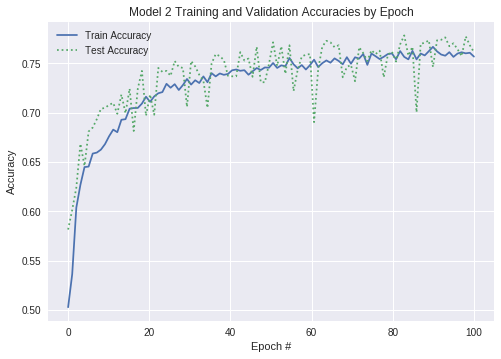

In [0]:
train_acc_df_1=pd.DataFrame(fitted_model_2.history["acc"])
train_val_acc_df_1=pd.DataFrame(fitted_model_2.history["val_acc"])

fig = plt.figure()
ax = plt.axes()
x = np.linspace(0, 100,100)
plt.plot(x, train_acc_df_1, label='Train Accuracy')
plt.plot(x, train_val_acc_df_1, linestyle='dotted', label='Test Accuracy')
plt.title("Model 2 Training and Validation Accuracies by Epoch")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()

NameError: ignored